In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels 
from statsmodels.tsa import stattools

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statannotations.Annotator import Annotator

from ssm_stats import EsmssmStats
stats = EsmssmStats()
from ssm_prep_data import EsmssmDataPrep
prep = EsmssmDataPrep()
from ssm_plotting import EsmssmPlotting
plotting = EsmssmPlotting()

# Define filepath
filepath = '../../results/modelfits/'

# Define path to save figures
figpath = '../../results/paper_figures/'
savefig = False

In [2]:
# Load singledataset
df = pd.read_csv(filepath + '../../data/data_prep/singledataset/split3/mooddata.csv', delimiter=',')
df_input = pd.read_csv(filepath + '../../data/data_prep/singledataset/split3/inputdata.csv')

# Load modelfit for singledataset
mat = scipy.io.loadmat(filepath + 'singledataset/split3/ssmfit_r2.mat')

# Number of phases
NP = len(mat['fit'][0])

# Define dimensions
mood_columns = ['cheerful', 'content', 'anxious', 'sad']
phase_labels = ['baseline', 'discontinuation', 'after transition']

# Define dynamic matrix labels
A_columns = [mood_columns[j] + r' $\rightarrow$ ' + mood_columns[i] for i in range(4) for j in range(4)]
A_columns_idx = [mood_columns[j] + r' $\rightarrow$ ' + mood_columns[i] + r' (a$_{' + \
                 str(i+1) + str(j+1) + '}$)' for i in range(4) for j in range(4)]


In [3]:
# Extract parameter estimates from mat file
data = []
for i in range(NP):
    subdata = dict()
    subdata['timing'] = mat['fit'][0][i][0][0][1]
    subdata['numberMeasurements'] = len(subdata['timing'])
    subdata['data'] = mat['fit'][0][i][0][0][2]
    subdata['datamean'] = np.nanmean(subdata['data'],1)
    subdata['inp'] = mat['fit'][0][i][0][0][3]
    subdata['A'] = mat['fit'][0][i][0][0][4]['A'][0][0] + mat['fit'][0][i][0][0][4]['W'][0][0]
    subdata['bias'] = mat['fit'][0][i][0][0][4]['h'][0][0]
    subdata['C'] = mat['fit'][0][i][0][0][4]['C'][0][0]
    subdata['latents'] = mat['fit'][0][i][0][0][4]['z'][0][0]
    subdata['ll'] = mat['fit'][0][i][0][0][4]['LL'][0][0][0]
    data.append(subdata)

In [4]:
# Create depression and input dataframes
df_depression = pd.DataFrame()
phase_list = df['id'].dropna().unique()
NP = len(phase_list)
ii = df_input.copy()
input_columns = df_input.columns[2:]
actual_inputs = np.empty(((len(input_columns)),NP))
for d in ['1', '2', '_change']:
    for j, i in enumerate(phase_list):
        idx = df['id'] == i
        df_depression.loc[j, 'dep' ] = df['dep'][idx].mean(skipna=True)
        actual_inputs[:,j] = ~np.isnan(ii[idx].iloc[0,2:]).values & ~(ii[idx].iloc[:,2:].sum() == 0)
C_labels = [i + ' - ' + j for i in mood_columns for j in input_columns]

In [5]:
# Summary statistics for the three different phases
summary_stats = pd.DataFrame(columns=['# of measurments'] + mood_columns \
                             + ['depression'], index=range(3))
summary_stats['# of measurments'] = pd.DataFrame(data)['numberMeasurements']
summary_stats['depression'] = df_depression.round(2)
for n, m in enumerate(mood_columns): 
    for s in range(NP):
        summary_stats.loc[s, m] = str(np.round(np.nanmean(data[s]['data'][n,:]),2)) + ' ± ' + \
            str(np.round(np.nanstd(data[s]['data'][n,:]),2))
summary_stats.index = phase_labels
summary_stats.round(2).T

,baseline,discontinuation,after transition
# of measurments,176,495,411
cheerful,4.06 ± 0.76,4.11 ± 0.83,4.07 ± 0.89
content,4.11 ± 0.93,4.29 ± 1.0,4.15 ± 1.01
anxious,3.9 ± 0.34,3.87 ± 0.35,3.95 ± 0.23
sad,4.07 ± 0.57,4.04 ± 0.64,4.37 ± 0.81
depression,1.26,1.23,1.93


In [6]:
# Extract dynamics and control features
dynamics, basic_char = prep.extract_dynamic_features(data, control_features=True, input_columns=input_columns, inputs=actual_inputs)

In [7]:
# Controllability and stability over three phases
import control as con
df_feature_phases = pd.DataFrame()
for i in range(3):
    C = con.ctrb(data[i]['A'],data[i]['C'])
    df_feature_phases.loc[i, 'controllability'] = np.round(np.linalg.norm(C),2)
    df_feature_phases.loc[i, 'stability'] = np.round(np.linalg.det(data[i]['A']),2)
df_feature_phases.index = phase_labels
df_feature_phases

,controllability,stability
baseline,4.49,0.84
discontinuation,1.81,0.88
after transition,1.44,0.88


dominant singular value: [4.20043323 1.48294192 1.06671964]


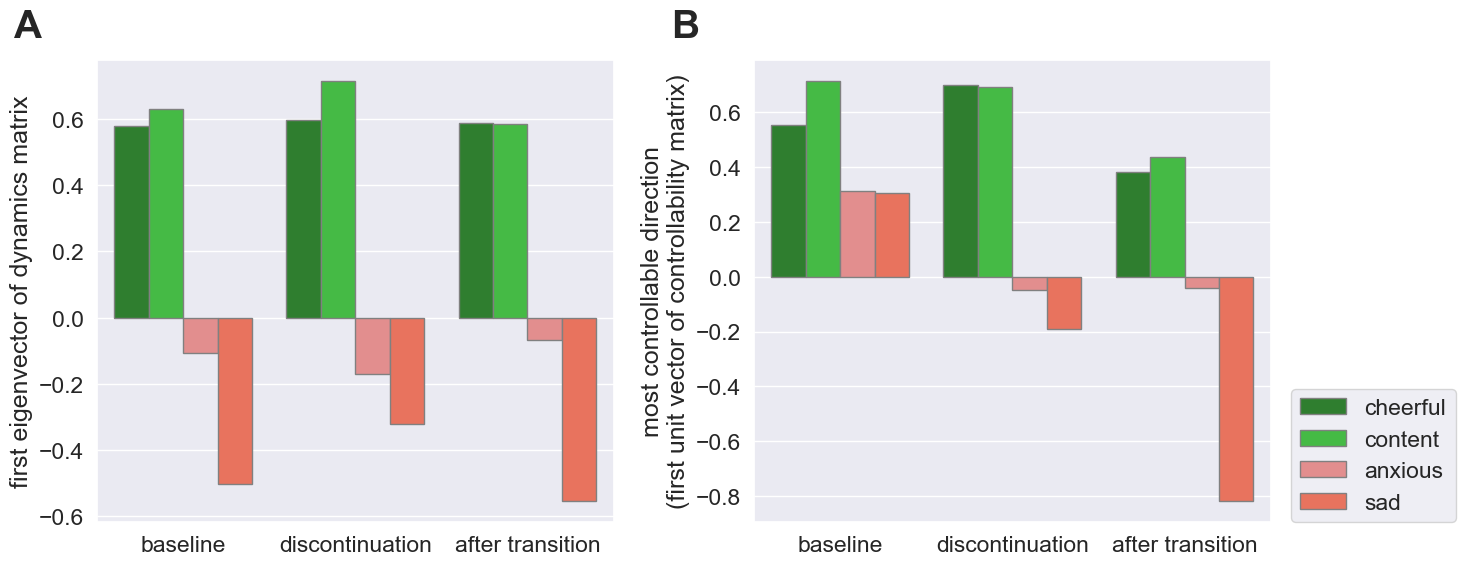

In [8]:
# Plot slowest eigenvector and most controllable direction
sns.set(font_scale=1.5)
fig,ax=plt.subplots(1,2,figsize=(15,6))
ll = ['first eigenvector of dynamics matrix', 'most controllable direction\n(first unit vector of controllability matrix)']
for i, j in enumerate([dynamics['vec_aligned'], -dynamics['convec']]):
    df = pd.DataFrame(j[:,0,:])
    df['emotion'] = mood_columns
    df_melt = pd.melt(df, id_vars='emotion')
    b = sns.barplot(data=df_melt, x="variable", y="value", hue="emotion", \
                edgecolor=".5", palette=['forestgreen','limegreen','lightcoral','tomato'],ax=ax[i])
    b.set(xlabel='', xticklabels=phase_labels, ylabel=ll[i]);
    b.text(-0.16, 1.05, ['A', 'B'][i], transform=b.transAxes, weight='bold', size=28);
    b.legend([],[], frameon=False)
b.legend(loc=(1.04, 0));
plt.tight_layout()
if savefig: plt.savefig(figpath + 'malamud_fig6_wichers.png')
print('dominant singular value: ' + str(dynamics['conval'][0,:]))

# Optimal Control

In [9]:
# Run optimal control algorithm to infer input sequence that transitions system to a desired state
from optimal_control import OptimalControl
optimal = OptimalControl()
optimal_control_input = np.full((len(input_columns),100,NP), np.nan)
state = np.full((4,100,NP), np.nan)
for i in range(NP):
    dt = 1.0
    actual_state_x = np.array([1,1,7,7]) 
    desired_state_xf = np.array([7,7,1,1])  
    A = dynamics['matrix'][:,:,i]
    B = dynamics['conmatrix'][:, ~np.isnan(dynamics['conmatrix'][:,:,i]).any(axis=0),i]
    Q = np.eye(4)
    R = np.eye(B.shape[1])
    t=0
    while (sum(abs(actual_state_x - desired_state_xf)) > 1) and (t < 100-1):
        state[:,t,i] = actual_state_x
        opt = optimal.lqr(actual_state_x, desired_state_xf, Q, R, A, B, dt)
        optimal_control_input[(actual_inputs[:,i]==1),t,i] = opt
        actual_state_x = optimal.state_space_model(A, actual_state_x, B,opt)
        t+=1
    state[:,t,i] = actual_state_x

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_1742/412601221.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


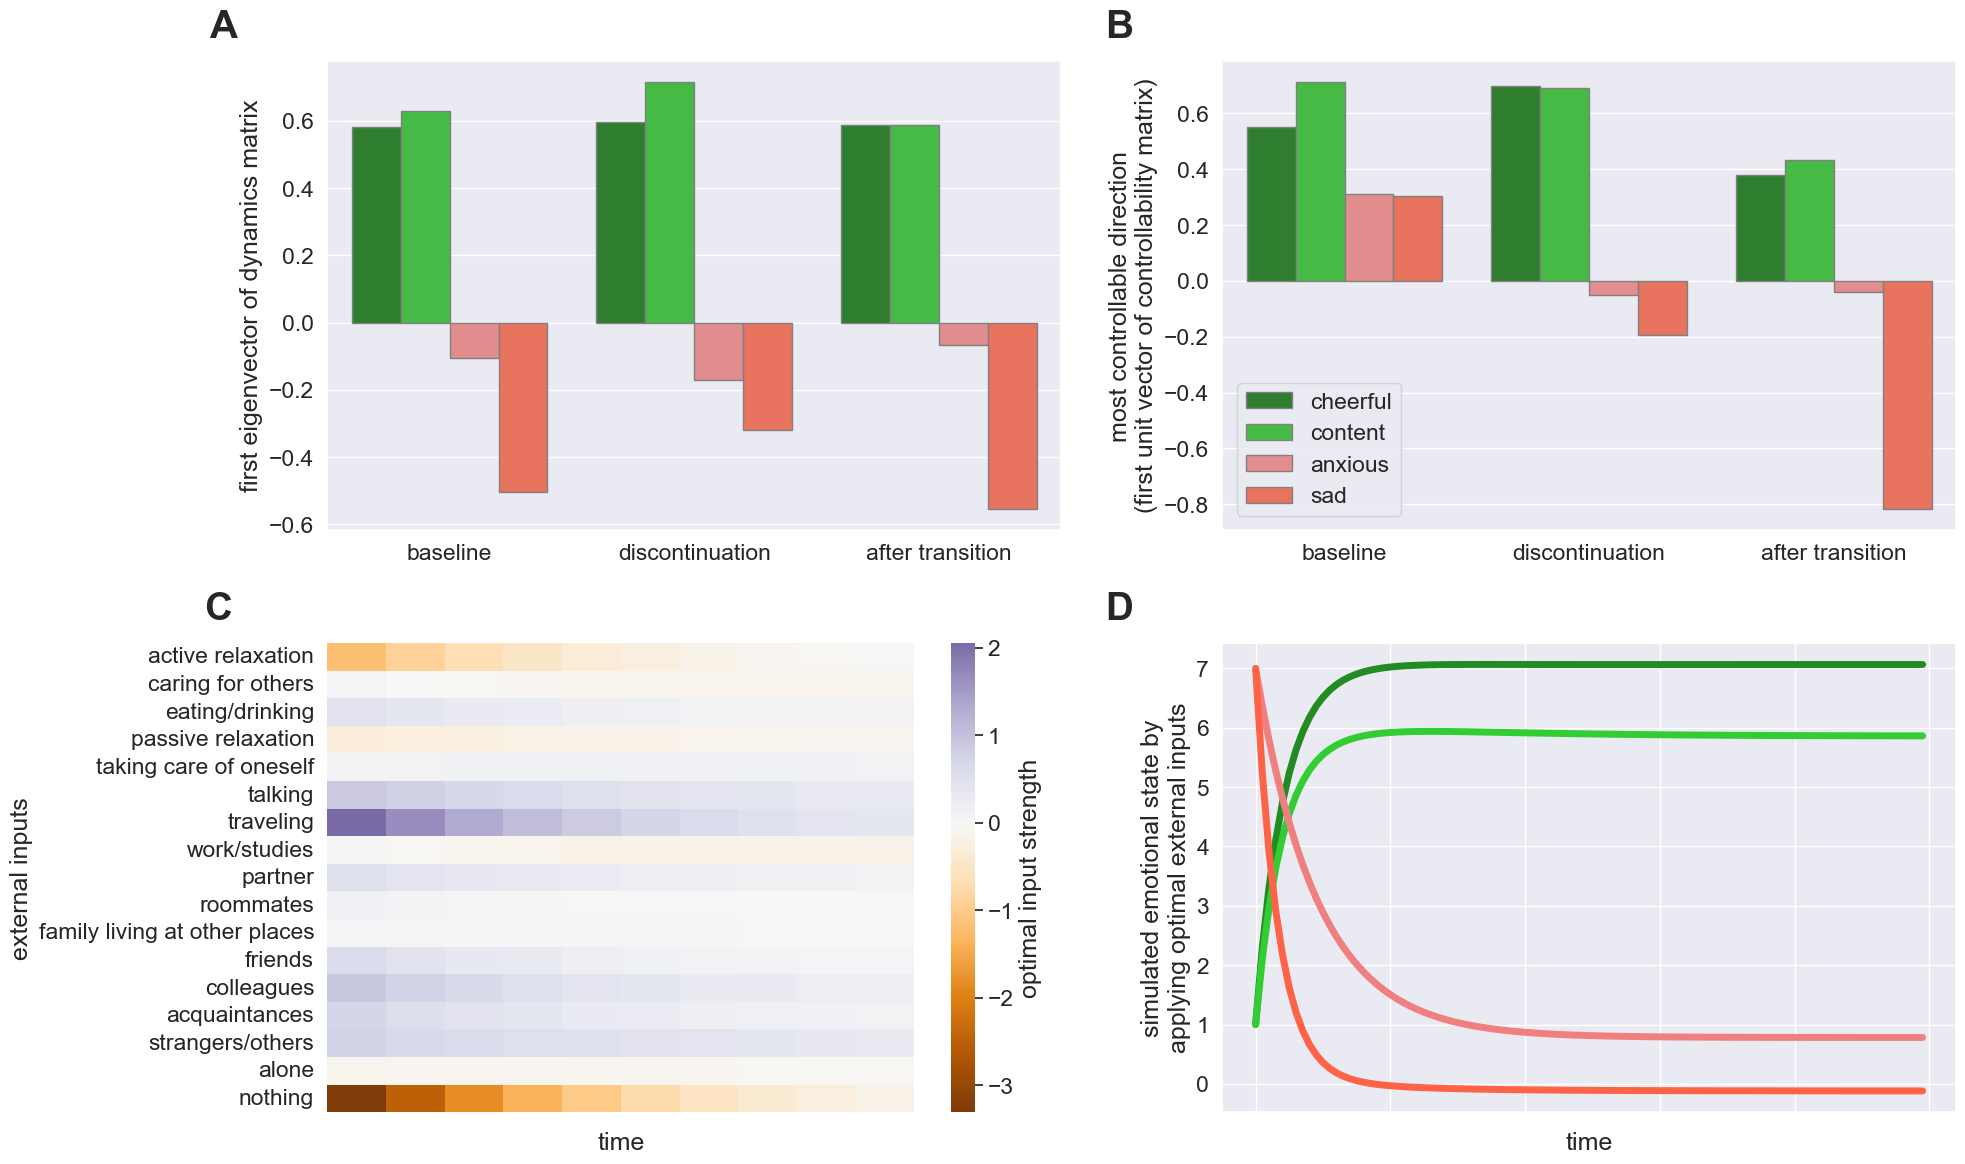

In [10]:
# Paperplot
# A) slowest eigenvector for three phases; B) most controllable direction for three phases;
# C) optimal input values over time; D) states over time under the influence of the optimal input
sns.set(font_scale=1.5)
palette=['forestgreen','limegreen','lightcoral','tomato']
fig,ax=plt.subplots(2,2,figsize=(20,12))
ll = ['first eigenvector of dynamics matrix', 'most controllable direction\n(first unit vector of controllability matrix)']
for i, j in enumerate([dynamics['vec_aligned'], -dynamics['convec']]):
    df = pd.DataFrame(j[:,0,:])
    df['emotion'] = mood_columns
    df_melt = pd.melt(df, id_vars='emotion')
    b = sns.barplot(data=df_melt, x="variable", y="value", hue="emotion", \
                edgecolor=".5", palette=palette,ax=ax[0,i])
    b.set(xlabel='', xticklabels=['baseline', 'discontinuation', 'after transition'], \
         ylabel=ll[i]);
    b.text(-0.16, 1.05, ['A', 'B'][i], transform=b.transAxes, weight='bold', size=28);
    b.legend([],[], frameon=False)
b.legend(loc=(0.02, 0.03));
plt.tight_layout()
# plt.savefig(figpath + 'wichser_results.png')
idx = ~np.isnan(optimal_control_input[:,:10,2]).all(axis=1)
b = sns.heatmap(optimal_control_input[idx,:10,2], yticklabels=input_columns[idx],ax=ax[1,0], \
                cbar_kws={'label':'optimal input strength'}, cmap='PuOr', center=0)
b.text(-0.21, 1.05, 'C', transform=b.transAxes, weight='bold', size=28);
b.set(xlabel='time', xticklabels=[], ylabel='external inputs');
for i in range(4):
    ax[1,1].plot(state[i,:,2].T, color=palette[i], linewidth=5)
ax[1,1].text(-0.16, 1.05, 'D', transform=ax[1,1].transAxes, weight='bold', size=28);
ax[1,1].set(xlabel='time', xticklabels=[], ylabel= 'simulated emotional state by\napplying optimal external inputs');
plt.tight_layout() 
if savefig: plt.savefig(figpath + 'wichers.svg', bbox_inches='tight')

# Supplementary Material

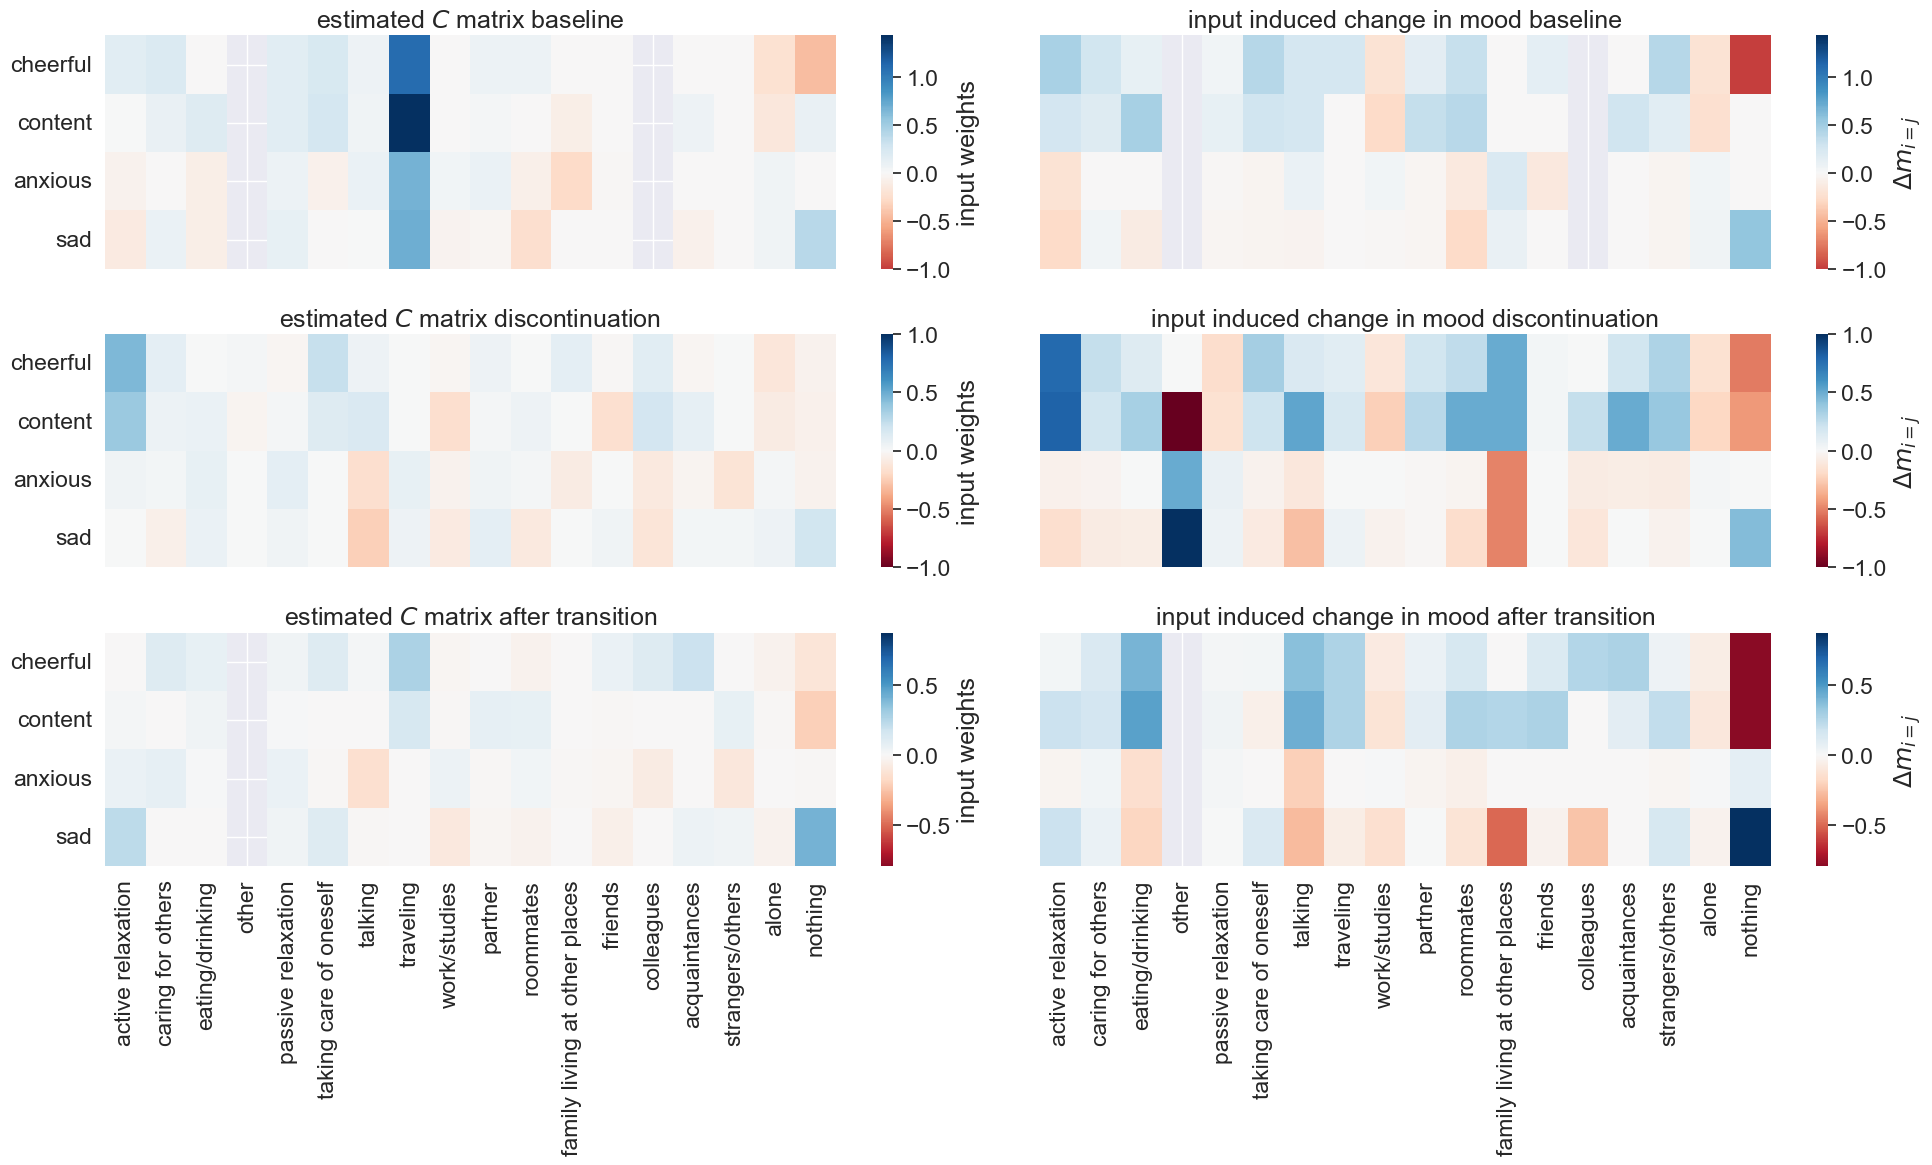

In [11]:
# Compare input matrix vs from raw data inferred input induced change
fig,ax=plt.subplots(3,2,figsize=(20,12))
for i in range(3):
    idx = actual_inputs[:,i]==1
    ii = np.full_like(dynamics['conmatrix'][:,:,i], np.nan)
    ii[:, idx] = stats.input_impact(data[i])
    vmin = min([min(dynamics['conmatrix'][:,:,i].flatten()),min(ii.flatten())])
    vmax = max([max(dynamics['conmatrix'][:,:,i].flatten()),max(ii.flatten())])
    a=sns.heatmap(dynamics['conmatrix'][:,:,i].round(2),ax=ax[i,0], \
                xticklabels=input_columns, yticklabels=mood_columns, \
                cmap='RdBu', center=0, cbar_kws={'label':'input weights'}, vmin=vmin, vmax=vmax)
    b=sns.heatmap(ii,ax=ax[i,1], \
                xticklabels=input_columns, yticklabels=[], \
                cmap='RdBu', center=0, vmin=vmin, vmax=vmax, cbar_kws={'label':'$\Delta m_{i=j}$'},)
    if i < 2:
        a.set_xticklabels([])
        b.set_xticklabels([])
    a.set_title('estimated $C$ matrix ' + phase_labels[i])
    b.set_title('input induced change in mood ' + phase_labels[i])
plt.tight_layout() 
if savefig: plt.savefig(figpath + 'supp_fig3_wichers_C.svg', bbox_inches='tight')

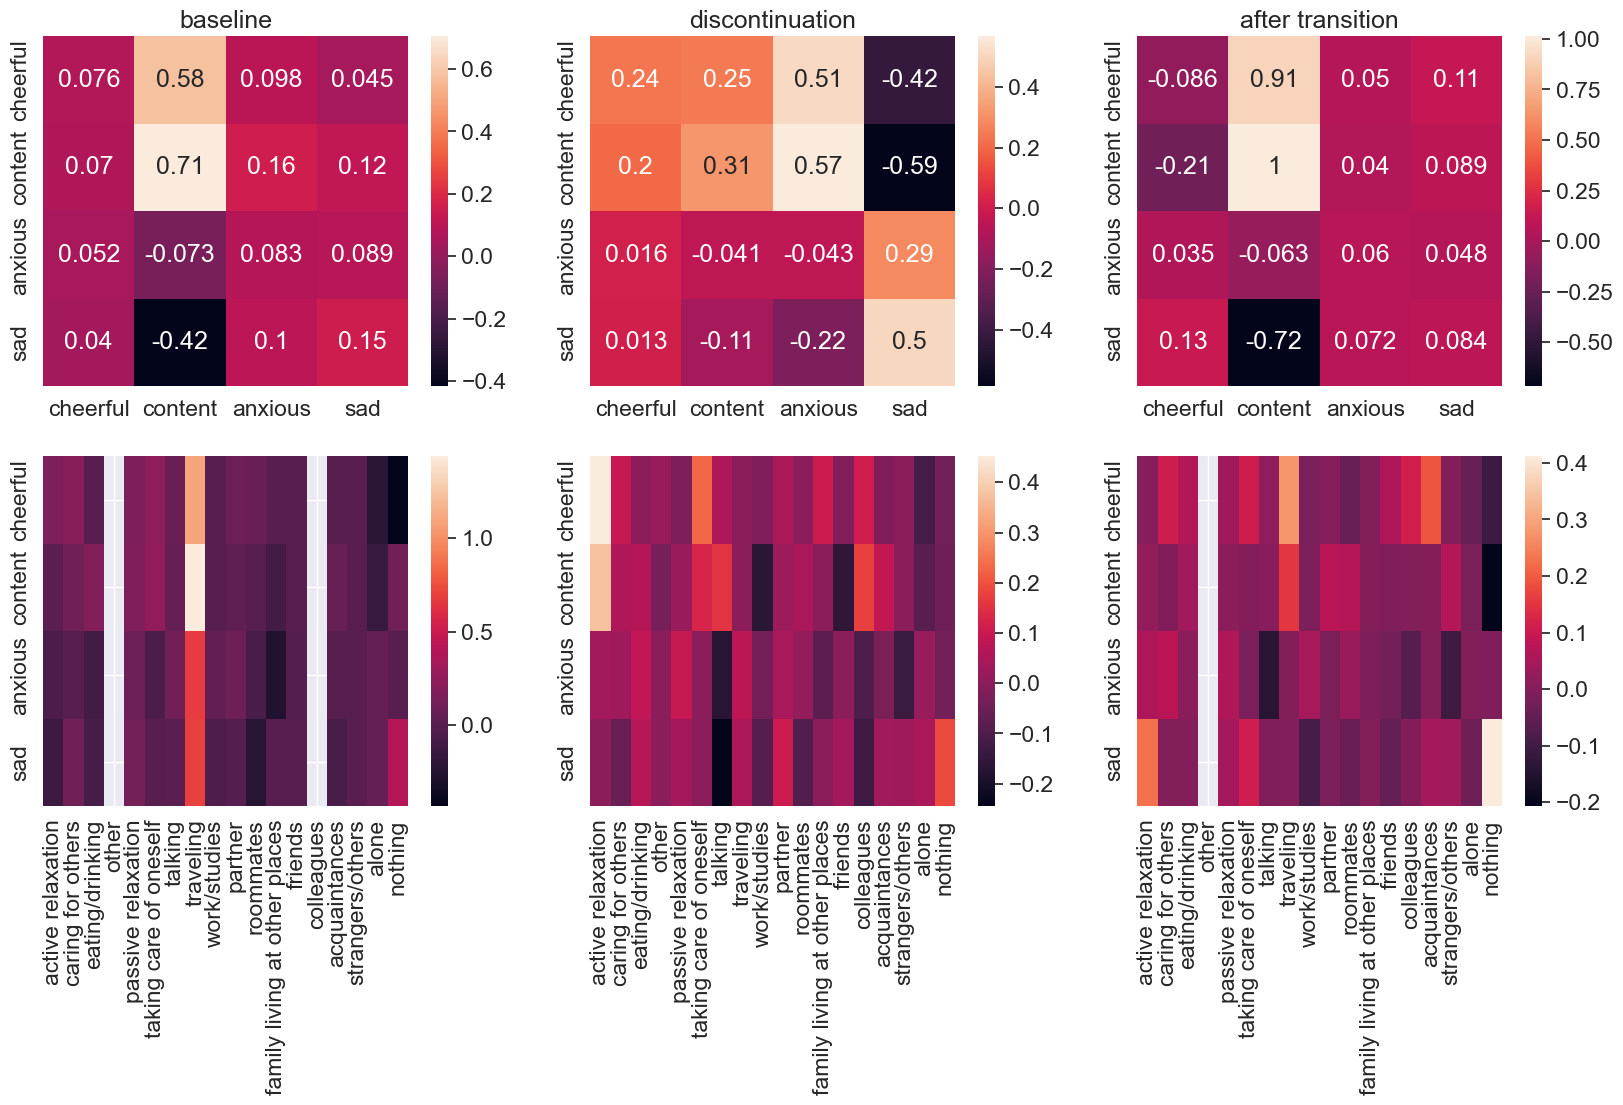

In [12]:
# Plot dynamics matrix for different phases
fig,ax=plt.subplots(2,3,figsize=(20,10))
for i in range(NP):
    sns.heatmap(dynamics['matrix_hour'][:,:,i], annot=True, \
            yticklabels=mood_columns, xticklabels=mood_columns, ax=ax[0,i])
    sns.heatmap(dynamics['conmatrix'][:,:,i], \
            yticklabels=mood_columns, xticklabels=input_columns, ax=ax[1,i])
    ax[0,i].set_title(phase_labels[i])

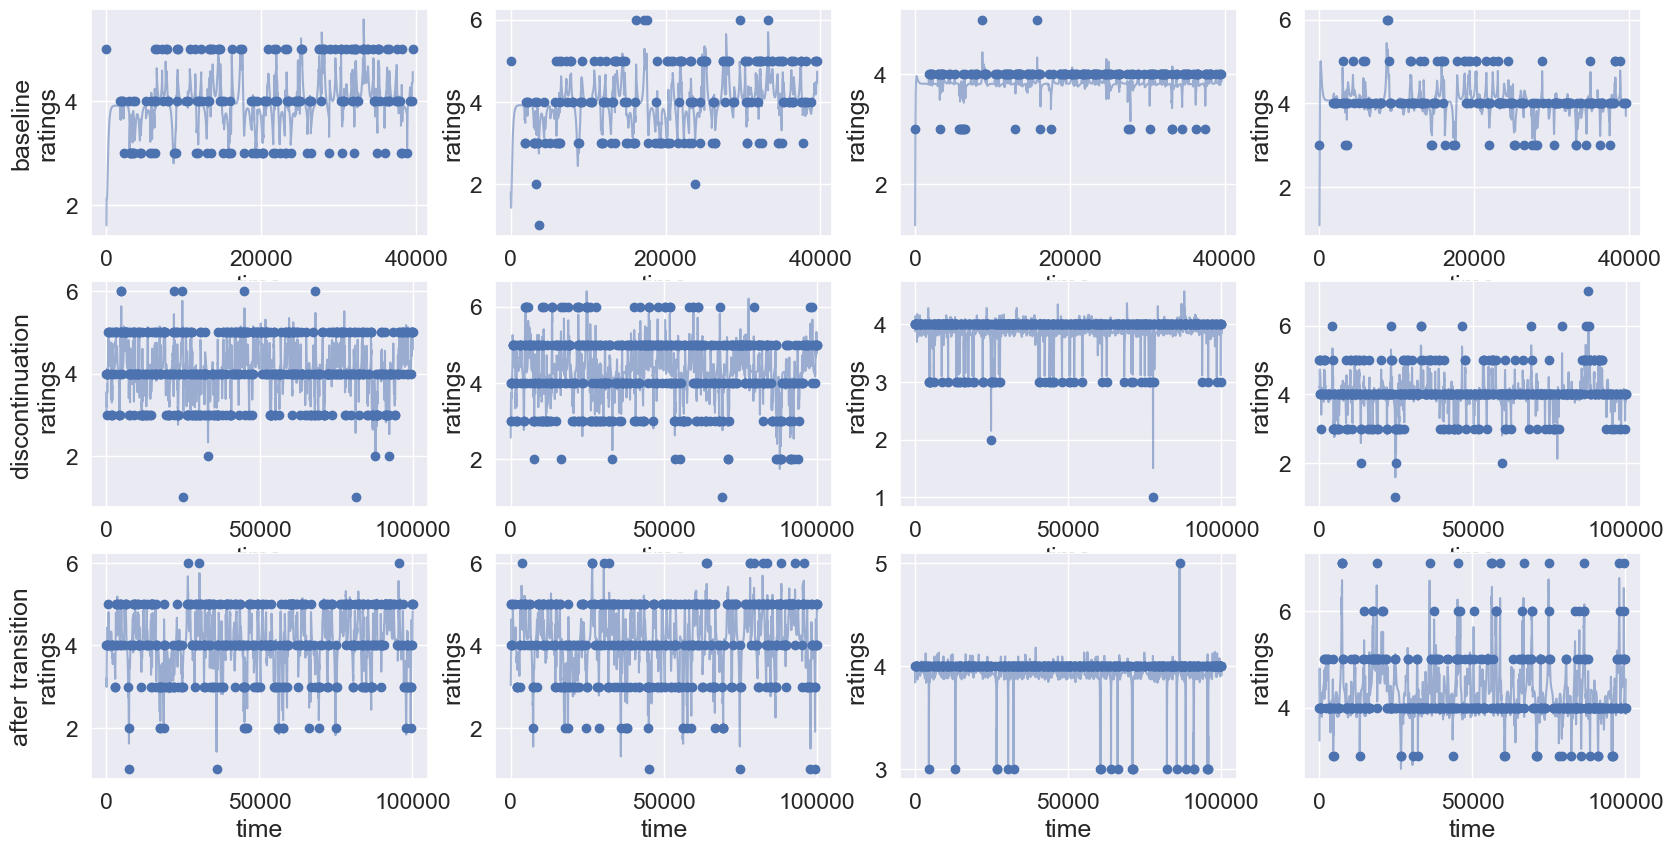

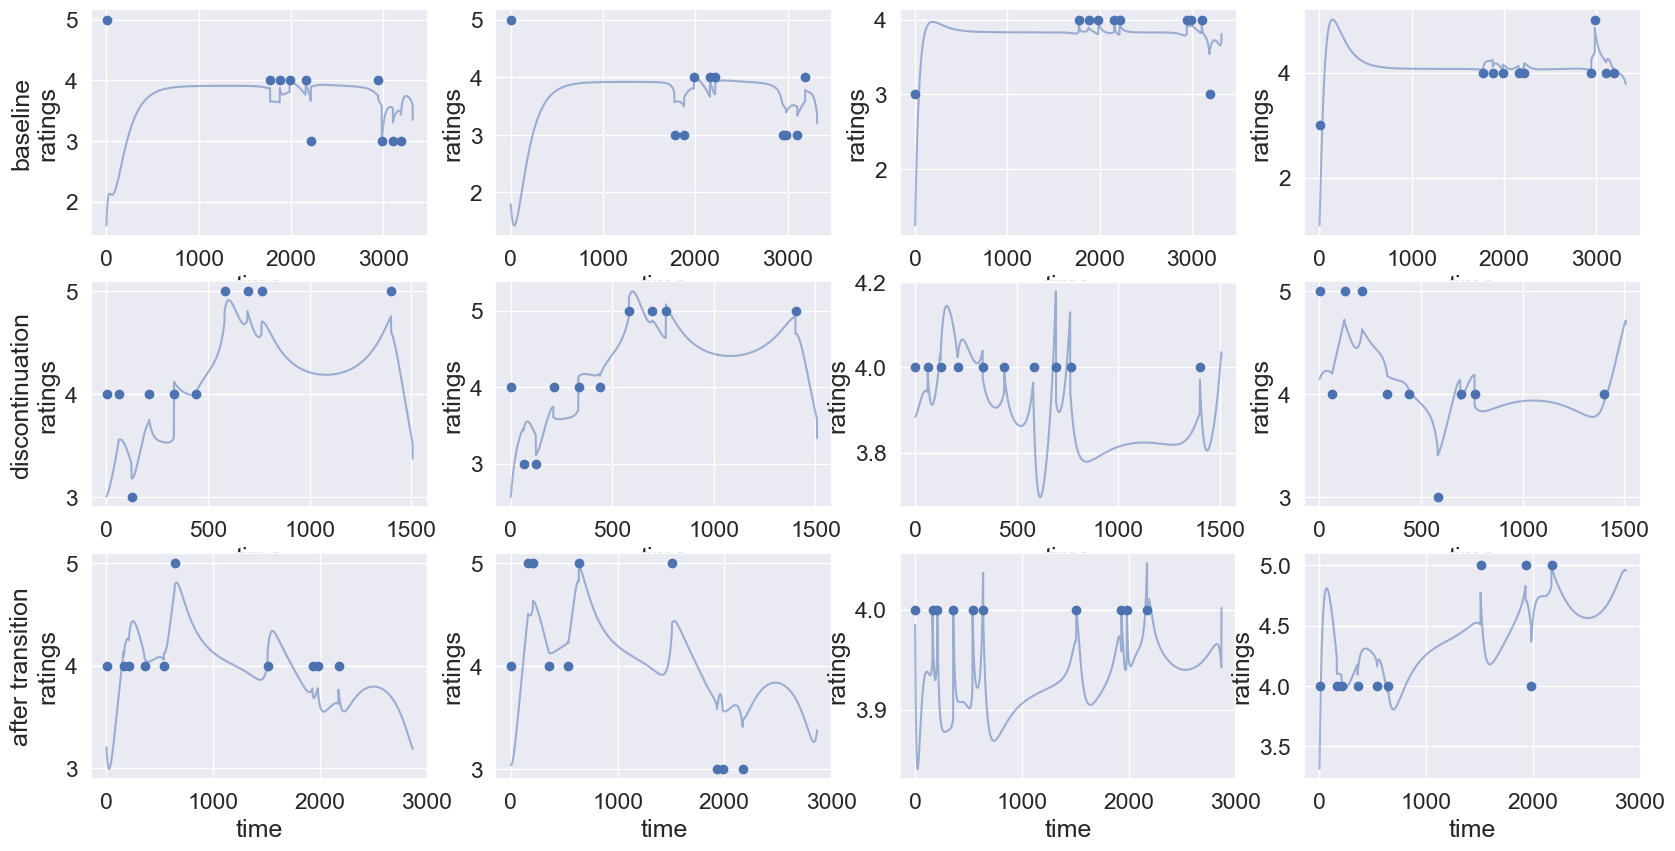

In [13]:
# Plot true observations and inferred latent states
fig,ax=plt.subplots(3,4,figsize=(20,10))
for i in range(NP):
    for m in range(4):
        ax[i,m].scatter(data[i]['timing'],data[i]['data'][m,~np.isnan(data[i]['data'][0,:])])
        ax[i,m].plot(data[i]['latents'][m,:], alpha=0.5)
        ax[i,m].set(ylabel='ratings', xlabel='time')
        if m == 0: ax[i,m].set(ylabel=phase_labels[i] + '\nratings')

# Plot true observations and inferred latent states (zoomed in)
fig,ax=plt.subplots(3,4,figsize=(20,10))
for i in range(NP):
    for m in range(4):
        ax[i,m].scatter(data[i]['timing'][:10],(data[i]['data'][m,~np.isnan(data[i]['data'][0,:])])[:10])
        ax[i,m].plot((data[i]['latents'][m,:])[:data[i]['timing'][10][0]], alpha=0.5)
        ax[i,m].set(ylabel='ratings', xlabel='time')
        if m == 0: ax[i,m].set(ylabel=phase_labels[i] + '\nratings')